In [1]:
import os
import time
from tqdm import tqdm
import exciting_environments as excenvs
import numpy as np
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt
from functools import partial


ModuleNotFoundError: No module named 'tqdm'

In [30]:
# Initialize random seeds
np.random.seed(0)
jax_key = jax.random.PRNGKey(0)

batch_size = 32
tau = 1e-2

# Initialize the environment
env = excenvs.make('Pendulum-v0', batch_size=batch_size, g = 9.81 ,  l=1, m=1, tau=tau, max_torque=2)



In [31]:
class PolicyNetwork(eqx.Module):
    layers: list[eqx.nn.Linear]
    
    def __init__(self, layer_sizes, key):
        self.layers = []
        for (fan_in, fan_out) in zip(layer_sizes[:-1], layer_sizes[1:]):
            key, subkey = jax.random.split(key)
            self.layers.append(
                eqx.nn.Linear(fan_in, fan_out, use_bias=True, key=subkey)
            )

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))
        return jnp.tanh(self.layers[-1](x))
    
    


In [4]:
'''ref_state = jnp.tile(jnp.array([[0, 0]]), (batch_size, 1)).astype(jnp.float32)

@eqx.filter_jit
def loss_fn(policy, initial_state, ref_state, key):
    # Constants
    #m, g, l = env.static_params['m'], env.static_params['g'], env.static_params['l']
    # Extract scalar values
    m, g, l = env.static_params['m'][0, 0], env.static_params['g'][0, 0], env.static_params['l'][0, 0]  
    
    #total_steps = 4000
    
    # during one control step
    def generate_actions(carry, _):
        state, key = carry
        key, subkey = jax.random.split(key)

        policy_params = jnp.concatenate([state, ref_state], axis=-1)
        action = jax.vmap(policy)(policy_params)
        

        next_state = jax.vmap(env._ode_exp_euler_step)(state, action, 
                                                       env.env_state_normalizer, env.action_normalizer, env.static_params)

        
            
        # Energy 
        #theta = next_state[:, 0]  
        #theta_dot = next_state[:, 1]  
        #print(f'theta shape: {theta.shape}')
        
        
        # PE
        #E_p = m * g * l * (1 - jnp.cos(theta))  
        

        # KE
        #E_k = 0.5 * m * (l * theta_dot)**2  # shape: (batch_size,)
        #print(f'E_p shape: {E_k.shape}')

        #E_current_t = E_p + E_k  
        

        # E_d dynamically
        #E_desired_t = m * g * l * (1 - jnp.cos((jnp.pi * (t + 1)) / total_steps)) 
        #print(f'E_desired_t shape: {E_desired_t.shape}' )
        
        
        return (next_state, key), (next_state, action, state)
            

        #return (next_state, key), (next_state, action, E_current_t, E_desired_t)

    #scan
    #(_, (predict_states, actions, E_current, E_desired)) = jax.lax.scan(generate_actions,(initial_state, key),  jnp.arange(total_steps))
    (_, (predict_states, actions, initial_states)) = jax.lax.scan(generate_actions, (initial_state, key), None, length=4000)
    

        
    #print(f'predict_states shape: {predict_states.shape}' )
    #print(f'actions shape: {actions.shape}' )
    #print(f'E_current shape: {E_current.shape}' )
    #print(f'E_desired shape: {E_desired.shape}' )
    
        
    # mse for deviation in position
    #mse = jnp.mean((predict_states - ref_state)**2)
    #W = jnp.array([[1, 0], [0, .5]])  
    #error_state = predict_states - ref_state 
    
    #mse = jnp.mean(jnp.einsum('...i,ij,...j->...', error_state, W, error_state))
 
    
    #et
    theta_et = predict_states[:, : ,  0]  
    theta_dot_et = predict_states[:, :,  1]  
    
    
    #m_exp = jnp.expand_dims(m.squeeze(), axis=0)
    #g_exp = jnp.expand_dims(g.squeeze(), axis=0)  
    #l_exp = jnp.expand_dims(l.squeeze(), axis=0)
    
    #m_exp = jnp.broadcast_to(m, (4000, 32))  
    #g_exp = jnp.broadcast_to(g, (4000, 32))  
    #l_exp = jnp.broadcast_to(l, (4000, 32)) 
    
    #PE
    E_p_et = m * g * l * (1 - jnp.cos(theta_et))
    #print(f'E_p_et shape: {E_p_et.shape}')

    #KE
    E_k_et = 0.5 * m * (l * theta_dot_et)**2  
    
    #total current E
    E_current_et = E_p_et + E_k_et  
    
    
    #ED at upper
    E_desired_et = m * g * l  
    
         

    # Penalize  E deviation  
    energy_penalty = E_desired_et - E_current_et
    #energy_penalty = jnp.mean((E_desired_et - E_current_et)**2)
    print(f'energy_penalty shape: {energy_penalty.shape}' )

    # Final loss function
    #loss = mse + energy_penalty
    loss =  energy_penalty

    return loss, predict_states, actions, initial_state
    
'''

"ref_state = jnp.tile(jnp.array([[0, 0]]), (batch_size, 1)).astype(jnp.float32)\n\n@eqx.filter_jit\ndef loss_fn(policy, initial_state, ref_state, key):\n    # Constants\n    #m, g, l = env.static_params['m'], env.static_params['g'], env.static_params['l']\n    # Extract scalar values\n    m, g, l = env.static_params['m'][0, 0], env.static_params['g'][0, 0], env.static_params['l'][0, 0]  \n    \n    #total_steps = 4000\n    \n    # during one control step\n    def generate_actions(carry, _):\n        state, key = carry\n        key, subkey = jax.random.split(key)\n\n        policy_params = jnp.concatenate([state, ref_state], axis=-1)\n        action = jax.vmap(policy)(policy_params)\n        \n\n        next_state = jax.vmap(env._ode_exp_euler_step)(state, action, \n                                                       env.env_state_normalizer, env.action_normalizer, env.static_params)\n\n        \n            \n        # Energy \n        #theta = next_state[:, 0]  \n        #theta_dot

In [32]:
# Placeholder for reference state
ref_state = jnp.tile(jnp.array([[0, 0]]), (batch_size, 1)).astype(jnp.float32)


@eqx.filter_jit
def loss_fn(policy, initial_state, ref_state, key , horizon_length):
    def generate_actions(carry, _):
        state, key = carry
        key, subkey = jax.random.split(key)
        #error_state = ref_state - state
        policy_params = jnp.concatenate([state, ref_state], axis=-1)
        
        

        action = jax.vmap(policy)(policy_params)
        
        
        
        next_state = jax.vmap(env._ode_exp_euler_step)(state, action,
                                                       env.env_state_normalizer, env.action_normalizer, env.static_params)
        return (next_state, key), (next_state, action, state)

    #(_, (predict_states, actions, initial_states)) = jax.lax.scan(generate_actions, (initial_state, key), None, length=5)
    (_, (predict_states, actions, initial_states)) = jax.lax.scan(generate_actions, (initial_state, key), None, horizon_length)
    
    mse = jnp.mean((predict_states - ref_state)**2)
    
    # initiate w1 and w2 with appropriate weights
    #W = jnp.array([[1, 0], [0, .5]])  
    #error_state = predict_states - ref_state 
    
    #mse = jnp.mean(jnp.einsum('...i,ij,...j->...', error_state, W, error_state))
 
    
    return mse , predict_states, actions, initial_states



In [33]:

@eqx.filter_value_and_grad
def compute_loss(policy, initial_state, key):
    mse_loss, _, _, _ = loss_fn(policy, initial_state, ref_state, key,horizon_length)
    return mse_loss


In [34]:
@eqx.filter_jit
def update_state(policy, initial_state, key, opt_state):
    loss, grads = compute_loss(policy, initial_state, key)
    updates, opt_state = optimizer.update(grads, opt_state)
    policy = eqx.apply_updates(policy, updates)
    return loss, policy, opt_state


In [35]:
def train_random_initial_state(key, batch_size):
    
    #Define the ranges around downward equilibrium
    theta_min_pos_rad = np.deg2rad(175)
    theta_max_pos_rad = np.deg2rad(5)
    theta_min_neg_rad = np.deg2rad(-175)
    theta_max_neg_rad = np.deg2rad(-5)
    
    # Generate keys for random number generation
    keys = jax.random.split(key, batch_size )
    
    # Generate random angles in both ranges
    thetas_pos = jax.vmap(lambda k: jax.random.uniform(k, minval=theta_min_pos_rad, maxval=theta_max_pos_rad))(keys[:int(batch_size/2)])
    thetas_neg = jax.vmap(lambda k: jax.random.uniform(k, minval=theta_min_neg_rad, maxval=theta_max_neg_rad))(keys[int(batch_size/2):])
    
    # Concatenate and shuffle to mix angles from both ranges
    thetas = jnp.concatenate([thetas_pos, thetas_neg])
    thetas = jax.random.permutation(keys[0], thetas)
    
    # Normalize the angles to the range [-pi, pi]
    thetas = (thetas + jnp.pi) % (2 * jnp.pi) - jnp.pi
    
    # Normalize to [1, -1] as per  environment
    return jnp.stack([thetas / jnp.pi, jnp.zeros_like(thetas)], axis=1)

In [43]:
key, subkey = jax.random.split(jax.random.PRNGKey(0))

#LAYERS = [4, 20, 20, 20, 1]
LAYERS = [4, 64, 64, 64, 1]
#LAYERS = [4, 64, 128, 64, 1]
#LAYERS = [4, 128, 128, 128, 1]
#LAYERS = [4, 20, 1]


policy = PolicyNetwork(LAYERS, key=key)

In [44]:

learning_rate = 1e-3

#optimizer = optax.adam(learning_rate)
#optimizer = optax.adam(learning_rate, b1=0.9, b2=0.999, eps=1e-8, amsgrad=True) #AMSGrad 
#optimizer = optax.nadam(learning_rate) #Nesterov momentum
#optimizer = optax.radam(learning_rate) #Rectified Adam (RAdam) and Lookahead
#optimizer = optax.rmsprop(learning_rate)
#optimizer = optax.rmsprop(learning_rate, decay=0.9, eps=1e-8)
#optimizer = optax.sm3(learning_rate)
#optimizer = optax.sgd(learning_rate, momentum=0.9 , nesterov= False )
#optimizer = optax.noisy_sgd(learning_rate)
#optimizer = optax.polyak_sgd( f_min = 0.3, eps = 1e-8)


optimizer = optax.sgd(learning_rate)


opt_state = optimizer.init(policy)


In [49]:
#num_epochs = 5
#num_epochs = 10
#num_epochs = 500
#num_epochs = 700
#num_epochs = 1000
num_epochs = 10000
#num_epochs = 15000
#num_epochs = 17000
#num_epochs = 20000

losses = []
state_trajectories = []
action_trajectories = []

start_time = time.time()

#for epoch in tqdm(range(num_epochs), desc="Training Progress", ncols=100):
for epoch in range(num_epochs):
    jax_key, subkey = jax.random.split(jax_key)
    batch_initial_states = train_random_initial_state(subkey, batch_size)
    loss, policy, opt_state = update_state(policy, batch_initial_states, subkey, opt_state)
    losses.append(loss.item())
    
    train_horizon_length = 500
    
    _, predicted_states, actions, initial_states = loss_fn(policy, batch_initial_states, ref_state, subkey , train_horizon_length)
    
    
    state_trajectories.append(predicted_states)
    action_trajectories.append(actions)
    
    # loss at every 100th  epoch
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}")
    
    
        


# Total training time
total_training_time = time.time() - start_time
print(f"Training time: {total_training_time:.2f} seconds")
 
    

Epoch 100: Loss = 0.4023
Epoch 200: Loss = 0.3929
Epoch 300: Loss = 0.3896
Epoch 400: Loss = 0.3750
Epoch 500: Loss = 0.4037
Epoch 600: Loss = 0.3791
Epoch 700: Loss = 0.3684
Epoch 800: Loss = 0.3771
Epoch 900: Loss = 0.3844
Epoch 1000: Loss = 0.3744
Epoch 1100: Loss = 0.3859
Epoch 1200: Loss = 0.3767
Epoch 1300: Loss = 0.3697
Epoch 1400: Loss = 0.3778
Epoch 1500: Loss = 0.3665
Epoch 1600: Loss = 0.3886
Epoch 1700: Loss = 0.3773
Epoch 1800: Loss = 0.3717
Epoch 1900: Loss = 0.3850
Epoch 2000: Loss = 0.3679
Epoch 2100: Loss = 0.3561
Epoch 2200: Loss = 0.3867
Epoch 2300: Loss = 0.3907
Epoch 2400: Loss = 0.3968
Epoch 2500: Loss = 0.3701
Epoch 2600: Loss = 0.3832
Epoch 2700: Loss = 0.3901
Epoch 2800: Loss = 0.3792
Epoch 2900: Loss = 0.3666
Epoch 3000: Loss = 0.3455
Epoch 3100: Loss = 0.3844
Epoch 3200: Loss = 0.3881
Epoch 3300: Loss = 0.3760
Epoch 3400: Loss = 0.3908
Epoch 3500: Loss = 0.3698
Epoch 3600: Loss = 0.3798
Epoch 3700: Loss = 0.3813
Epoch 3800: Loss = 0.3936
Epoch 3900: Loss = 0.

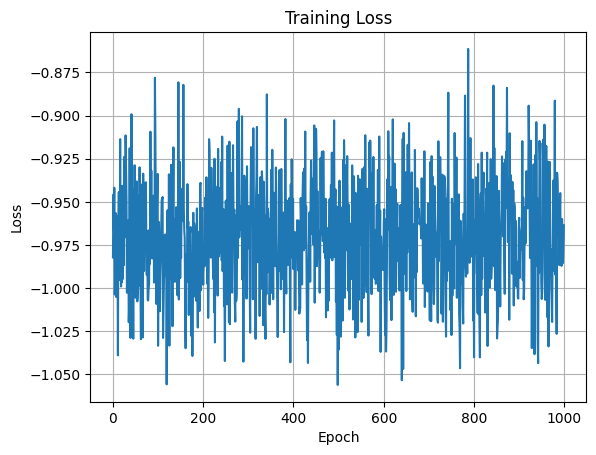

In [46]:
#save_dir = 'TrainingLoss'
#os.makedirs(save_dir, exist_ok=True)

plt.plot(jnp.log(jnp.array(losses)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

#plt.savefig('training_loss.pdf')
#plt.savefig(os.path.join(save_dir, 'training_loss.pdf'))
plt.close()

In [47]:
def test_random_initial_state(key, batch_size):
    
    #Define the ranges around downward equilibrium
    theta_min_pos_rad = np.deg2rad(175)
    theta_max_pos_rad = np.deg2rad(160)
    theta_min_neg_rad = np.deg2rad(-175)
    theta_max_neg_rad = np.deg2rad(-160)
    
    # Generate keys for random number generation
    keys = jax.random.split(key, batch_size )
    
    # Generate random angles in both ranges
    thetas_pos = jax.vmap(lambda k: jax.random.uniform(k, minval=theta_min_pos_rad, maxval=theta_max_pos_rad))(keys[:int(batch_size/2)])
    thetas_neg = jax.vmap(lambda k: jax.random.uniform(k, minval=theta_min_neg_rad, maxval=theta_max_neg_rad))(keys[int(batch_size/2):])
    
    # Concatenate and shuffle to mix angles from both ranges
    thetas = jnp.concatenate([thetas_pos, thetas_neg])
    thetas = jax.random.permutation(keys[0], thetas)
    
    # Normalize the angles to the range [-pi, pi]
    thetas = (thetas + jnp.pi) % (2 * jnp.pi) - jnp.pi
    
    # Normalize to [1, -1] as per  environment
    return jnp.stack([thetas / jnp.pi, jnp.zeros_like(thetas)], axis=1) 



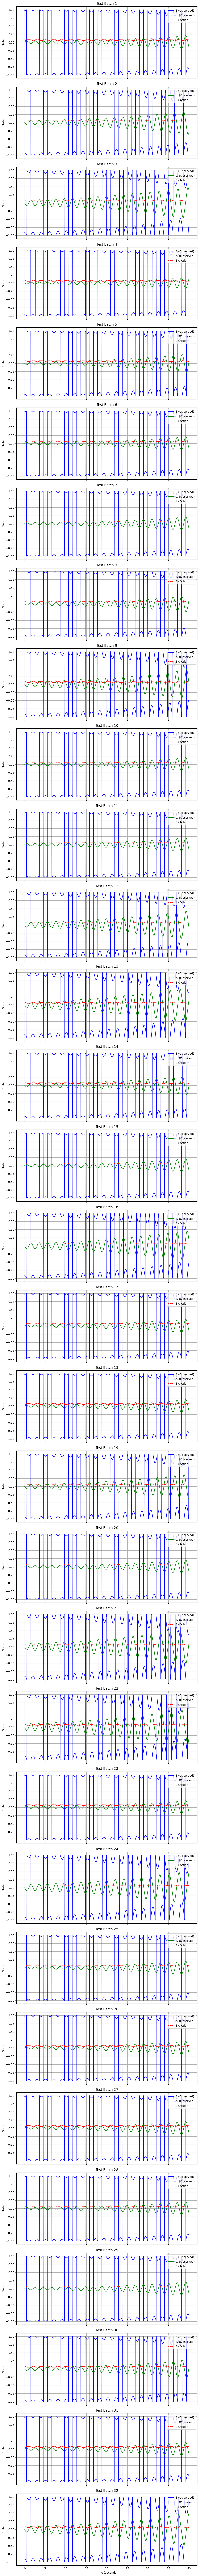

Test Loss: 0.41757285594940186


In [48]:
# Test Evaluation Function
def evaluate_policy(policy, key, batch_size):
    test_horizon_length = 4000
    key, subkey = jax.random.split(key)
    test_initial_states = test_random_initial_state(subkey, batch_size)
    loss, predicted_states, actions, initial_states = loss_fn(policy, test_initial_states, ref_state, subkey , test_horizon_length)
    return loss, predicted_states, actions, initial_states

# Test 
key_test = jax.random.PRNGKey(1)
test_loss, test_predicted_states, test_actions, test_initial_states = evaluate_policy(policy, key_test, batch_size)



# Plot test results
time_axis = jnp.arange(test_predicted_states.shape[0]) * tau
fig, axes = plt.subplots(batch_size, 1, figsize=(10, 4 * batch_size), sharex=True)

for i in range(batch_size):
    axes[i].plot(time_axis, test_predicted_states[:, i, 0], label=r'$\theta$ (Observed)', color='b')
    axes[i].plot(time_axis, test_predicted_states[:, i, 1], label=r'$\omega$ (Observed)', color='g')
    axes[i].plot(time_axis, test_actions[:, i], 'r--', label=r'$\theta$ (Action)')
    axes[i].set_title(f'Test Batch {i+1}')
    axes[i].set_ylabel('State')
    axes[i].legend(loc='upper right')
    axes[i].grid()

axes[-1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.grid()
plt.show()

print(f"Test Loss: {test_loss}")
